In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import timedelta 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import seaborn as sns
import glob
import re

from src.utils import *
from src.features.build_features import *


In [ ]:
data_dir = '.\data'
answers_path = os.path.join(data_dir,'answers')

In [ ]:
DATASET_VER = 5.2
insiders_df = pd.read_csv(os.path.join(answers_path,"insiders.csv"))
insiders_df = insiders_df[(insiders_df['dataset'] == DATASET_VER)]
insiders_df['start'] = pd.to_datetime(insiders_df['start'])
insiders_df = insiders_df.sort_values(by='start', ascending=True)
insiders_df.head()

,dataset,scenario,details,user,start,end
177,5.2,4,r5.2-4-OHS0036.csv,OHS0036,2010-04-16 12:32:57,07/09/2010 10:32:40
148,5.2,3,r5.2-3-MPF0690.csv,MPF0690,2010-06-17 10:00:38,06/18/2010 20:22:06
111,5.2,2,r5.2-2-VCF1602.csv,VCF1602,2010-06-23 15:32:14,08/11/2010 18:01:01
128,5.2,2,r5.2-2-CKP0630.csv,CKP0630,2010-06-28 08:13:30,08/13/2010 12:59:03
115,5.2,2,r5.2-2-ZIE0741.csv,ZIE0741,2010-06-29 13:16:09,08/27/2010 18:13:31


In [ ]:
mal_users_events = read_malicious_events(answers_path)

# Load fine data

In [ ]:
import glob 

feature_dfs = []
features_path = os.path.join(data_dir,'features/*.csv')
for path in glob.glob(features_path):
  df = pd.read_csv(path)
  feature_dfs.append(df)

In [ ]:
from functools import reduce

fine_features = reduce(lambda left, right: pd.merge(left, right, on=['user', 'day'],
                                               how='outer'), feature_dfs).fillna(0)
fine_features['day'] = pd.to_datetime(fine_features['day'])
fine_features['is_malicious'] = fine_features.apply(is_malicious_day, 
                                                       args=[mal_users_events],
                                                       axis=1)

fine_features

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,day,user,count_Receive_working_hour_personal_pc_0_0,count_Send_working_hour_personal_pc_0_0,count_Receive_working_hour_personal_pc_1_0,count_Send_working_hour_personal_pc_1_0,count_Send_working_hour_personal_pc_1_1,count_Receive_after_hours_personal_pc_0_0,count_Receive_after_hours_personal_pc_1_0,count_Send_after_hours_personal_pc_0_0,...,file_length,file_depth_y,count_Logon_working_hour_other_pc,count_Logon_working_hour_personal_pc,count_Logon_after_hours_other_pc,count_Logon_after_hours_personal_pc,count_Logon_after_hours_supervisor_pc,count_Logon_working_hour_supervisor_pc,session_time,is_malicious
0,2010-01-02,ELT1370,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,163.666667,0
1,2010-01-02,ESM1828,5.0,5.0,12.0,7.0,4.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,276.500000,0
2,2010-01-02,GVM1337,5.0,4.0,5.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,277.000000,0
3,2010-01-02,HJB1444,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
4,2010-01-02,ILM1441,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,261.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62525,2011-01-15,JOB0532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,118.000000,0
62526,2011-02-27,JOB0532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49.000000,0
62527,2011-03-19,CTM1817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,194.000000,0
62528,2011-03-19,GDC0055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,57.000000,0


# Train/test splits by user

In [ ]:
train_users, test_users = sample_random_users(fine_features, insiders_df)
drop_cols = ["day", "user", "is_malicious"]

In [ ]:
user_train_features_fine = fine_features[fine_features['user'].isin(train_users)]
user_test_features_fine = fine_features[fine_features['user'].isin(test_users)]

X_train_user_fine = user_train_features_fine.drop(columns=drop_cols)
y_train_user_fine = user_train_features_fine.iloc[:, -1]

X_test_user_fine = user_test_features_fine.drop(columns=drop_cols)
y_test_user_fine = user_test_features_fine.iloc[:, -1]

print(f"train shape: {X_train_user_fine.shape}")
print(f"test shape: {X_test_user_fine.shape}")

train shape: (47704, 102)
test shape: (14826, 102)


# Load best model

In [ ]:
import pickle

model_path = os.path.join(data_dir, f"models/xgboost.sav")
best_model = pickle.load(open(model_path, 'rb'))

In [ ]:
#TODO: Move this to config file

top_features = ['url_depth', 'count_Send_working_hour_other_pc_1_0',
       'count_webvisit', 'file_depth_x', 'count_jobsearch_webvisit',
       'count_Connect_working_hour_personal_pc', 'connection_time',
       'url_length', 'file_depth_y', 'session_time', 'file_length',
       'count_File Open_pdf_False_working_hour_other_pc',
       'count_File Open_doc_False_working_hour_other_pc', 'no_words',
       'size', 'http_content_length', 'no_attachments',
       'attachments_size', 'no_destinations', 'no_external_dest',
       'no_attachments_type',
       'count_Receive_working_hour_personal_pc_0_0',
       'count_Receive_working_hour_personal_pc_1_0',
       'count_Send_working_hour_personal_pc_1_0',
       'count_Send_working_hour_personal_pc_0_0', 'count_social_webvisit',
       'count_hacktivist_webvisit',
       'count_File Open_doc_True_working_hour_personal_pc', 'no_bcc_dest',
       'count_File Write_doc_False_working_hour_personal_pc']

X_train_top_features = X_train_user_fine[top_features]
X_test_top_features = X_test_user_fine[top_features]

In [ ]:
features = ['day','user'] + list(top_features) + ['is_malicious'] 

final_df = fine_features.loc[:,features]

malicious_X = X_test_top_features[y_test_user_fine == 1]
malicious_y = y_test_user_fine[y_test_user_fine == 1]

malicious_preds = best_model.predict(malicious_X)
mis_clf = malicious_X[malicious_y != malicious_preds]

test_malicious_idxs = X_test_top_features[y_test_user_fine == 1].index.values
mis_clf_idxs = mis_clf.index.values

test_malicious_df = final_df.loc[test_malicious_idxs]
test_malicious_df["scenario"] = test_malicious_df['user'].apply(lambda x: insiders_df[insiders_df['user']==x].scenario.values[0])
test_malicious_df["correctly_clf"] = [1] * test_malicious_df.shape[0]
test_malicious_df.loc[mis_clf_idxs, "correctly_clf"] = 0 

# Average attack length

In [ ]:
insiders_df['end'] = pd.to_datetime(insiders_df['end'])
insiders_df['duration'] = (insiders_df['end'] - insiders_df['start']).dt.days
insiders_df.head()

,dataset,scenario,details,user,start,end,duration
177,5.2,4,r5.2-4-OHS0036.csv,OHS0036,2010-04-16 12:32:57,2010-07-09 10:32:40,83
148,5.2,3,r5.2-3-MPF0690.csv,MPF0690,2010-06-17 10:00:38,2010-06-18 20:22:06,1
111,5.2,2,r5.2-2-VCF1602.csv,VCF1602,2010-06-23 15:32:14,2010-08-11 18:01:01,49
128,5.2,2,r5.2-2-CKP0630.csv,CKP0630,2010-06-28 08:13:30,2010-08-13 12:59:03,46
115,5.2,2,r5.2-2-ZIE0741.csv,ZIE0741,2010-06-29 13:16:09,2010-08-27 18:13:31,59


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


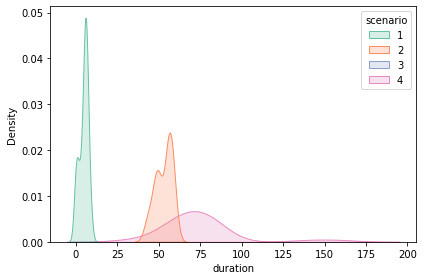

In [ ]:
import seaborn as sns

sns.kdeplot(data=insiders_df, x="duration", hue="scenario", palette='Set2', fill=True)
plt.tight_layout()
plt.savefig("Average attack duration.png", dpi=100)

# Number of days of each attack in test data

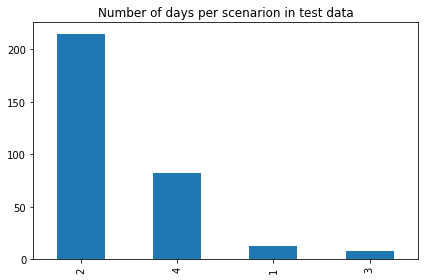

In [ ]:
test_malicious_df.scenario.value_counts().plot.bar(title="Number of days per scenarion in test data")
plt.tight_layout()
plt.savefig("Number of instances in test data.png", dpi=100)

# Detection Delay

<Figure size 432x288 with 0 Axes>

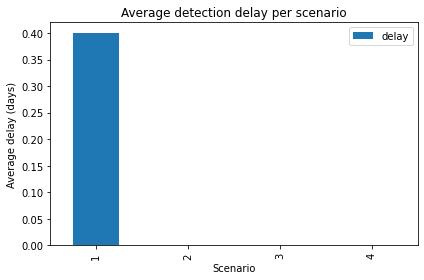

In [ ]:
delay = get_delay(test_malicious_df)
plt.figure()
delay.groupby(['scenario']).mean().plot.bar(title="Average detection delay per scenario")
plt.xlabel('Scenario')
plt.ylabel('Average delay (days)')
plt.tight_layout()
plt.savefig("Avg detection delay bar.png", dpi=100)

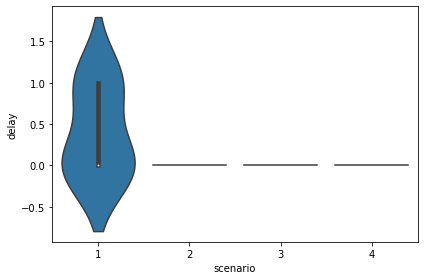

In [ ]:
import seaborn as sns 

sns.violinplot(data=delay, x='scenario', y='delay')
plt.tight_layout()
plt.savefig("Avg detection delay violin.png", dpi=100)

# Misclassifications per scenario

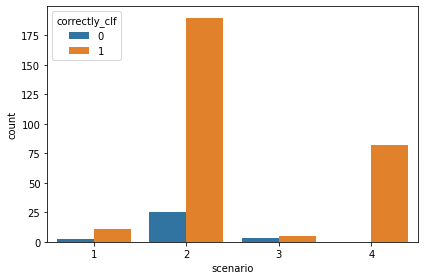

In [ ]:
import seaborn as sns
ax = sns.countplot(x="scenario", hue="correctly_clf", data=test_malicious_df)
plt.tight_layout()
plt.savefig("Accuracy per scneario.png", dpi=100)